### Bond Fluctuation Model

Bond vector set: 
$B=P\pm\left(\begin{array}{c}
2\\
0\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
1\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
1\\
1
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
2\\
2\\
1
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
3\\
0\\
0
\end{array}\right)\bigcup P\pm\left(\begin{array}{c}
3\\
1\\
0
\end{array}\right)$

Lattice occupation: $\vec{r}
+\left(\begin{array}{c}1\\ 0\\ 0 \end{array}\right)
+\left(\begin{array}{c}0\\ 1\\ 0 \end{array}\right)
+\left(\begin{array}{c}0\\ 0\\ 1 \end{array}\right)
+\left(\begin{array}{c}1\\ 1\\ 0 \end{array}\right)
+\left(\begin{array}{c}1\\ 0\\ 1 \end{array}\right)
+\left(\begin{array}{c}0\\ 1\\ 1 \end{array}\right)
+\left(\begin{array}{c}1\\ 1\\ 1 \end{array}\right)$

In [2]:
%pylab notebook
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [3]:
class monomer:
    ''' monomer class with unique index, containing the coordinates, bondpartners and attributes of a single BFM monomer '''
    def __init__(self, idx_, coords_, attributes_, bonds_ = []):
        ''' setting properties of monomer:
        idx: unique index (int),
        coords: d-dimensional coordinates (np.array),
        attributes: dict of properties (python dict),
        bonds: list of neigbor indizees (np.array)'''
        self.idx = idx_
        self.coords = coords_
        self.attributes = attributes_
        self.bonds = bonds_
#


In [4]:
class validBonds:
    ''' class containing the bondset and utility to check if bonds are valid '''
    def __init__(self):
        self.allBonds = [( 2, 0, 0), (0,  2, 0), (0, 0,  2), # (2,0,0)
                         (-2, 0, 0), (0, -2, 0), (0, 0, -2),
                         (2, 1, 0), (2, 0, 1), (0, 2, 1), (0, 1, 2),(1, 2, 0),(1, 0, 2), # (2,1,0)
                         (-2, 1, 0), (-2, 0, 1), (0, -2, 1), (0, 1, -2),(1, -2, 0),(1, 0, -2),
                         (2, -1, 0), (2, 0, -1), (0, 2, -1), (0, -1, 2),(-1, 2, 0),(-1, 0, 2),
                         (-2, -1, 0), (-2, 0, -1), (0, -2, -1), (0, -1, -2),(-1, -2, 0),(-1, 0, -2),
                         ( 2, 1, 1), (1,  2, 1), (1, 1,  2), # (2,1,1)
                         ( -2, 1, 1), (-1,  2, 1), (-1, 1,  2),
                         ( 2, -1, 1), (1,  -2, 1), (1, -1,  2),
                         ( 2, 1, -1), (1,  2, -1), (1, 1,  -2),
                         ( -2, -1, 1), (-1,  -2, 1), (-1, -1,  2),
                         ( 2, -1, -1), (1,  -2, -1), (1, -1,  -2),
                         ( -2, 1, -1), (-1,  2, -1), (-1, 1,  -2),
                         ( -2, -1, -1), (-1,  -2, -1), (-1, -1,  -2),
                         (2, 2, 1), (2, 1, 2), (1, 2, 2), # (2,2,1)
                         (-2, 2, 1), (-2, 1, 2), (-1, 2, 2),
                         (2, -2, 1), (2, -1, 2), (1, -2, 2),
                         (2, 2, -1), (2, 1, -2), (1, 2, -2),
                         (-2, -2, 1), (-2, -1, 2), (-1, -2, 2),
                         (2, -2, -1), (2, -1, -2), (1, -2, -2),
                         (-2, 2, -1), (-2, 1, -2), (-1, 2, -2),
                         (-2, -2, -1), (-2, -1, -2), (-1, -2, -2),
                         ( 3, 0, 0), (0,  3, 0), (0, 0,  3), # (3,0,0)
                         (-3, 0, 0), (0, -3, 0), (0, 0, -3),
                         (3, 1, 0), (3, 0, 1), (0, 3, 1), (0, 1, 3),(1, 3, 0),(1, 0, 3), # (3,1,0)
                         (-3, 1, 0), (-3, 0, 1), (0, -3, 1), (0, 1, -3),(1, -3, 0),(1, 0, -3),
                         (3, -1, 0), (3, 0, -1), (0, 3, -1), (0, -1, 3),(-1, 3, 0),(-1, 0, 3),
                         (-3, -1, 0), (-3, 0, -1), (0, -3, -1), (0, -1, -3),(-1, -3, 0),(-1, 0, -3)
                        ]
        self.lookup = np.zeros((512))
        # setup lookup table without check
        for b in self.allBonds:
            idf = self.bondToIdentifier(b)
            self.lookup[idf]=1
        
    def bondToIdentifier(self, b):
        ''' return a unique hash for every bond to use the fast lookup table self.lookup '''
        return (b[0] & 7) + ((b[1] &7) << 3) + ((b[2] &7) << 6)
    
    def checkBondInSet(self, b):
        ''' return True if bond b is part of the valid bondset or False otherwise '''
        return self.lookup[(self.bondToIdentifier(b))]
    
#


In [5]:
class excludedVolumeLattice:
    ''' class providing a lookup lattice to implement excluded volume checks in BFM simulations '''
    def __init__(self, box_):
        ''' setup of zero valued lattice with sizes taken from the box'''
        self.boxX, self.boxY, self.boxZ = box_
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        
    def fold_back(self,x,y,z):
        ''' fold back function to account for periodic boundary conditions '''
        myX = (((x% self.boxX)+ self.boxX)% self.boxX)
        myY = (((y% self.boxY)+ self.boxY)% self.boxY)
        myZ = (((z% self.boxZ)+ self.boxZ)% self.boxZ)

        return myX, myY, myZ
    
    def setMonomer(self, x,y,z):
        ''' set the position of a monomer.
        Sanity Check: check if lattice positions are free before overwriting them
        '''
        if( (self.lattice[self.fold_back(x  ,y  ,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z  )]
          + self.lattice[self.fold_back(x  ,y+1,z  )]
          + self.lattice[self.fold_back(x  ,y  ,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z+1)]
          + self.lattice[self.fold_back(x  ,y+1,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z+1)])
           != 0
          ):
            return False
            #raise ValueError("monomer position {} already occupied ".format([x,y,z]))
        else: 
            self.lattice[self.fold_back(x  ,y  ,z  )] = 1
            self.lattice[self.fold_back(x+1,y  ,z  )] = 1
            self.lattice[self.fold_back(x  ,y+1,z  )] = 1
            self.lattice[self.fold_back(x  ,y  ,z+1)] = 1
            self.lattice[self.fold_back(x+1,y+1,z  )] = 1
            self.lattice[self.fold_back(x+1,y  ,z+1)] = 1
            self.lattice[self.fold_back(x  ,y+1,z+1)] = 1
            self.lattice[self.fold_back(x+1,y+1,z+1)] = 1

            return True
        
    def clearMonomer(self, x, y, z):
        ''' remove the previous position of a monomer.
        Sanity Check: check if lattice positions are occupied before overwriting them
        '''
        if( (self.lattice[self.fold_back(x  ,y  ,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z  )]
          + self.lattice[self.fold_back(x  ,y+1,z  )]
          + self.lattice[self.fold_back(x  ,y  ,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z+1)]
          + self.lattice[self.fold_back(x  ,y+1,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z+1)])
           != 8
          ):
            return False
            #raise ValueError("monomer position {} was not occupied ".format([x,y,z]))
        else:
            self.lattice[self.fold_back(x  ,y  ,z  )] = 0
            self.lattice[self.fold_back(x+1,y  ,z  )] = 0
            self.lattice[self.fold_back(x  ,y+1,z  )] = 0
            self.lattice[self.fold_back(x  ,y  ,z+1)] = 0
            self.lattice[self.fold_back(x+1,y+1,z  )] = 0
            self.lattice[self.fold_back(x+1,y  ,z+1)] = 0
            self.lattice[self.fold_back(x  ,y+1,z+1)] = 0
            self.lattice[self.fold_back(x+1,y+1,z+1)] = 0

            return True
        
    def syncLattice(self,molecules):
        ''' set lattice to zero again and apply the current lattice occupation from molecules '''
        # reset lattice
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        # refresh lattice occupation
        for m in molecules:
            self.setMonomer(m.coords[0],m.coords[1],m.coords[2])
        
    def checkLattice(self,newPos,move):
        ''' check if a new position of a BFM unit is free on the lattice
        by taking the coordinates of the new anchor and the move coordinates '''
        # shift position by one if move in positive direction to keep the cube
        refPos = 1*newPos
        if ( np.any((np.array(move) > 0)) ):
            refPos += move
            
        # get perpendicular directions to move direction
        #(1 0 0) or (0 1 0)
        perX1 = 1 if move[0]==0 else 0
        perY1 = 1 if move[0]!=0 else 0
        # (0 1 0) or (0 0 1)
        perY2 = 0 if move[2]==0 else 1
        perZ2 = 0 if move[2]!=0 else 1
        #print(move,(perX1,perY1,0),(0,perY2,perZ2))
        
        # check if lattice sites are free
        if(self.lattice[self.fold_back(refPos[0],refPos[1],refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1,refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0],refPos[1]+perY2,refPos[2]+perZ2)] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1+perY2,refPos[2]+perZ2)] == 1):
            return False
        
        # if they are free return true
        return True
    
    def moveOnLattice(self,oldPos,newPos):
        ''' update lattice by move: simply delete the old lattice sites and occupy the new ones '''
        if self.clearMonomer(oldPos[0],oldPos[1],oldPos[2]):
            self.setMonomer(newPos[0],newPos[1],newPos[2])
            return True
        else:
            return False

In [6]:
class BFMSimulator:
    ''' class providing utilities for 3D BFM simulations:
    monomer container, bondset, move and apply function '''
    def __init__(self, box_, periodicity_):
        ''' setting up simulation box:
        box = [boxX, boxY, boxZ] (python list of int),
        periodicity = [pX, pY, pZ] (python list of bools), True = is periodic, False = wall
        bondset (instance of class validBonds)
        ... and setup:
        empty molecules as empty list,
        empty lattice (boxX*boxY*boxZ) with 0 as initial value (np.array),
        list of moves (python list)'''
        self.boxX, self.boxY, self.boxZ = box_
        self.pX, self.pY, self.pZ = periodicity_
        self.bondset = validBonds()
        self.molecules = []
        self.lattice = excludedVolumeLattice([self.boxX, self.boxY, self.boxZ])
        self.moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
        self.Nmoves = len(self.moves)
        self.setup = False
        
    def connectMonomers(self, idx1, idx2):
        ''' connect two monomers in molecules by index '''
        bond = (self.molecules[idx2].coords - self.molecules[idx1].coords)
        if ( self.bondset.checkBondInSet(bond) ):
            self.molecules[idx1].bonds.append(idx2)
            self.molecules[idx2].bonds.append(idx1)
        else:
            raise ValueError("bond between {} and {} is not valid: {}".format(idx1,idx2, bond))
        
    def addMonomer(self, coords, attributes):
        ''' add new monomer at the end of molecules '''
        newIdx = len(self.molecules)
        if not self.lattice.setMonomer(coords[0],coords[1],coords[2]):
            raise ValueError("Monomer {} could not be placed at ".format(newIdx,coords))
        self.molecules.append(monomer(newIdx ,coords, attributes,[]))
        
    def plotConfig(self):
        ''' plot all monomers using scatter and bonds using plot with the box as axis boundaries '''
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colorList = ["green","red"]
        
        myX = np.array([x.coords[0] for x in self.molecules])
        myY = np.array([x.coords[1] for x in self.molecules])
        myZ = np.array([x.coords[2] for x in self.molecules])
        
        mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
        for m in self.molecules:
            if (m.idx + 1) in m.bonds:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
            else:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
                ax.plot(mX,mY,mZ)
                mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
            
        #ax.plot(myX,myY,myZ)
        
        myFixed = [x.attributes["fixed"] for x in self.molecules]
        myColors = [colorList[int(c)] for c in myFixed ]
        ax.scatter(myX,myY,myZ, c=myColors)
        
        ax.set_xlim3d(0, self.boxX)
        ax.set_ylim3d(0, self.boxY)
        ax.set_zlim3d(0, self.boxZ)
        
        fig.show()
    
    def checkMove(self, idx, direction):
        ''' apply the move checks for monomer with index idx:
        takes monomer id and key of move direction [0,self.Nmoves)
        check the attribute fixed,
        check new bonds, check lattice, check boundaries'''
        # check fixed monomer attribute
        if "fixed" in self.molecules[idx].attributes:
            if (self.molecules[idx].attributes["fixed"] == True):
                return False
            
        # get new position
        newPos = self.molecules[idx].coords + self.moves[direction]
        x, y, z = newPos
        
        # check boundaries: 
        if not self.pX:
            if x == 0 or x == (self.boxX-1):
                return False
        if not self.pY:
            if y == 0 or y == (self.boxY-1):
                return False
        if not self.pZ:
            if z == 0 or z == (self.boxZ-1):
                return False   
        
        # check bonds
        for neighbIdx in self.molecules[idx].bonds:
            bnd = (newPos - self.molecules[neighbIdx].coords)
            if not ( self.bondset.checkBondInSet(bnd) ):
                return False
        
        # check lattice occupation
        if not self.lattice.checkLattice(newPos,self.moves[direction]):
            return False
        
        # if still here, all checks have been passed
        return True
        
    def applyMove(self,idx,direction):
        ''' apply a move: set new coordinate in molecules and update the lattice '''
        oldPos = 1*self.molecules[idx].coords
        newPos = (self.molecules[idx].coords + self.moves[direction])
        
        if self.lattice.moveOnLattice(oldPos, newPos):
            self.molecules[idx].coords = (newPos)
        else:
            print("error in apply move: Monomer {} in direction {} from {} to {}".format(idx,direction,oldPos,newPos))
        
    def performMCS(self,time):
        ''' apply the BFM algorithm on a given system for 'time' Monte Carlo sweeps '''
        if self.setup == False:
            self.lattice.syncLattice(self.molecules)
        counter = 0
        mol_size = len(self.molecules)
        for t in range(time):
            for n in range(mol_size):
                randomIdx = random.randint(mol_size)
                randomDir = random.randint(self.Nmoves)
                if self.checkMove(randomIdx,randomDir):
                    self.applyMove(randomIdx,randomDir)
                    counter += 1
            #self.lattice.syncLattice(self.molecules)
        #checkConfig()
        #print("applied moves / attempted moves:\n{} / {} = {}".format(counter, time*mol_size, counter/(time*mol_size)))
        
    #
    def checkConfig(self):
        ''' sanity check of the full simulation system '''
        nErrors = 0
        for m in self.molecules:
            for bp in m.bonds:
                bv = m.coords - self.molecules[bp].coords
                if self.bondset.checkBondInSet(bv) == False:
                    print("bond between {} and {} not valid: {}".format(m.idx,self.molecules[bp].idx,bv))
                    nErrors += 1
            if not self.pX:
                if (m.coords[0] < 0) or (m.coords[0] > (self.boxX-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pY:
                if (m.coords[1] < 0) or (m.coords[1] > (self.boxY-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pZ:
                if (m.coords[2] < 0) or (m.coords[2] > (self.boxZ-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
                    
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
                
        if self.lattice.lattice.sum() != (len(self.molecules)*8):
            print("total lattice occupation is inconsistent {}/{}".format(self.lattice.lattice.sum(), len(self.molecules)*8))
            nErrors += 1
            
        return nErrors
#

<IPython.core.display.Javascript object>


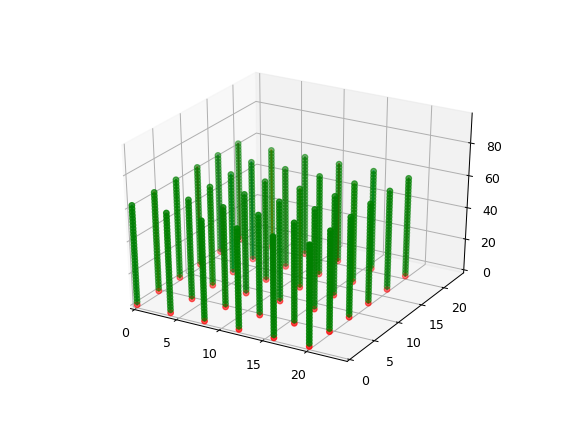

<IPython.core.display.Javascript object>


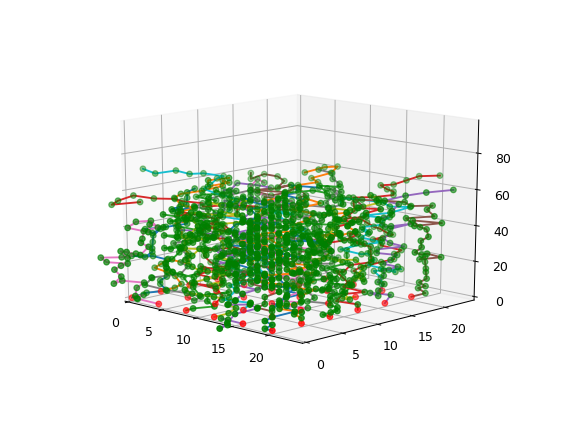

In [105]:
# Spielen mit Attributen und Parametern: Polymerbürste

# grafting densities 1/9, 1/16, 1/25
sigmaInv = 16
# Kettenlängen 32, ?
N = 32
# ketten array csp = 8x8 ? -> dauert ganz schön lange... besser 6x6?
nChainsPerDirection = 6

# ab hier wird alles aus den obigen Parametern berechnet:
'''----------------------------------------------------------'''
distanceInXYDirection = int(np.sqrt(sigmaInv))
distanceInZ = 2
myBoxXY = nChainsPerDirection*distanceInXYDirection

# setup Simulator
hugo = BFMSimulator( [myBoxXY,myBoxXY,N*3], [True, True, False] )

for dx in range(nChainsPerDirection):
    for dy in range(nChainsPerDirection):
        for z in range(N):
            coords = np.array([dx*distanceInXYDirection,dy*distanceInXYDirection,z*distanceInZ])
            if (z==0):
                attr = {"fixed": True}
            else:
                attr = {"fixed": False}
            hugo.addMonomer(coords,attr)
            if not z==0:
                hugo.connectMonomers(len(hugo.molecules)-2,len(hugo.molecules)-1)

# check config after creation
hugo.lattice.syncLattice(hugo.molecules)
hugo.checkConfig()
hugo.plotConfig()
#print(hugo.lattice.lattice)

# check config after some steps
hugo.performMCS(2000)
hugo.checkConfig()
hugo.plotConfig()
#print(hugo.lattice.lattice)

In [7]:
''' Aufgabe 1: Lineare Kette erstellen, Ree, Rg und Ree-Autocorrelationsfunktion berechnen '''

# lineare Kette, Rg, Re, ...
def setupLinearChain(N,box):
    '''
    create single linear chain of length N in a cubic box of size box
    Input: linear chain lenght N ( int ), box size in one dimension ( int )
    Return: instance of BFMSimulator
    '''
    chainSim = BFMSimulator( [box,box,box], [True, True, True] )
    steps = [(2,0,0),(0,2,0),(0,0,2)]
    attribute = {"fixed": False}

    for n in range(N):
        if (n > 0):
            step = steps[random.randint(len(steps))]
            coords = chainSim.molecules[-1].coords + step
            chainSim.addMonomer(coords,attribute)
            chainSim.connectMonomers(len(chainSim.molecules)-2,len(chainSim.molecules)-1)
        else:
            chainSim.addMonomer(np.array([0,0,0]),attribute)
    
    # sanity check before return
    chainSim.checkConfig()
            
    return chainSim

def separateMolecules(molecules):
    '''
    Find single molecules of successive linear chains
    Input: instance of molecules (list of monomers)
    Return: List of separated molecules (list of lists of monomers)
    '''
    singleMolecule = []
    separatedMolecules = []
    for m in molecules:
        if (m.idx + 1) in m.bonds:
            singleMolecule.append(m)
        else:
            singleMolecule.append(m)
            separatedMolecules.append(singleMolecule)
            singleMolecule = []
    
    return separatedMolecules

def calcRee(bfmSimulator):
    ''' 
    Sort all monomers to single molecules and calculate Ree vector for each of them
    Input: instance of BFMSimulator
    Return: List of np.arrays of Ree vectors, one for each (linear) molecule
    '''
    sepMol = separateMolecules(bfmSimulator.molecules)
            
    Ree = []
    for mol in sepMol:
        Ree.append(mol[-1].coords - mol[0].coords)
    return Ree

def calcRg2(bfmSimulator):
    ''' 
    Sort all monomers to single molecules and calculate Rg componentes in x,y,z for each of them
    Input: instance of BFMSimulator
    Return: List of np.arrays of Rg vectors, one for each (linear) molecule
    '''
    sepMol = separateMolecules(bfmSimulator.molecules)
            
    Rg2All = []
    for mol in sepMol:
        # calculate center of mass
        centerOfMass = np.zeros((3))
        for mono in mol:
            centerOfMass += mono.coords
        centerOfMass /= len(mol)
        
        # get mean squared distances to center of mass
        Rg2 = np.zeros((3))
        for mono in mol:
            diff = mono.coords - centerOfMass
            Rg2 += (diff*diff)
        Rg2 /= len(mol)
        Rg2All.append(Rg2)
        
    return Rg2All

In [78]:
np.array([2,2,3])*np.array([-1,2,0])

array([-2,  4,  0])

In [13]:
# setup linear chain
N = 32
boxXYZ = 64
chainSimulator = setupLinearChain(N,boxXYZ)

<IPython.core.display.Javascript object>


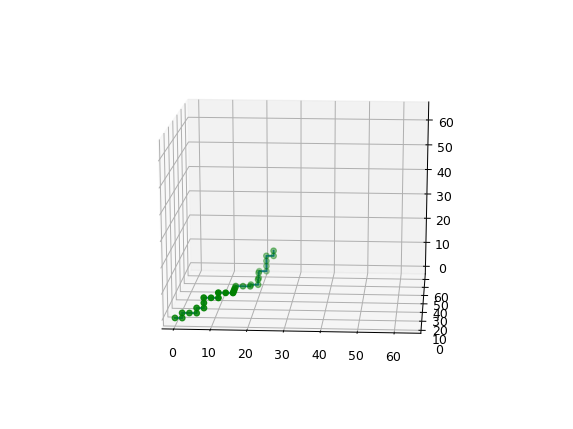

[array([26, 14, 22])]
[11.18732542]


In [14]:
# proof Ree, Rg, config
chainSimulator.plotConfig()
print(calcRee(chainSimulator))
print(np.sqrt(np.array(calcRg2(chainSimulator))))

In [10]:
# autocorrelation function
def sampleReDt(N,box,time):
    ''' function to get one sample of the autocorrelation of the end to end vector of a single BFM polymer chains'''
    # setup chain
    myChain = setupLinearChain(N,box)
    # short equilibration
    myChain.performMCS(100)
    
    # initial result container
    firstRe = calcRee(myChain)[0]
    ReDt = [np.dot(firstRe,firstRe)]
    Re2 = [np.dot(firstRe,firstRe)]
    
    # run the simulations
    for i in range(time-1):
        myChain.performMCS(1)
        currentRe = calcRee(myChain)[0]
        Re2.append(np.dot(currentRe,currentRe))
        ReDt.append(np.dot(firstRe,currentRe))
        
    # average the Re2
    reMean = sum(Re2)/len(Re2)
    # return the results
    return reMean, np.array(ReDt)

In [38]:
s_time = 100
n_sample = 10
N = 32
boxXYZ = 64

meanReDt = np.zeros(s_time)
reMean = 0.0

for n in range(n_sample):
    reC, redtC = sampleReDt(N, boxXYZ, s_time)
    # print(reC, redtC.size)
    reMean += reC
    meanReDt += redtC
    print(n+1, reMean/(n+1), meanReDt/(n+1))

reMean /= n_sample
meanReDt /= n_sample
print(reMean, meanReDt[:4])

applied moves / attempted moves:
920 / 3200 = 0.2875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.3

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / att

applied moves / attempted moves:
959 / 3200 = 0.2996875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
appli

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied move

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
7 1186.282857142857 [1304.14285714 1307.14285714 1305.28571429 1308.28571429 1296.14285714
 1292.28571429 1289.85714286 1281.14285714 1271.71428571 1276.71428571
 1276.28571429 1269.         1285.14285714 1291.57142857 1276.42857143
 1268.85714286 1267.71428571 1263.         1260.71428571 1263.28571429
 1263.14285714 1272.         1268.         1273.         1262.57142857
 1268.14285714 1254.85714286 1251.14285714 1244.28571429 1243.42857143
 1248.42857143 1232.14285714 1220.         1221.28571429 1218.71428571
 1201.28571429 1202.85714286 1200.57142857 1186.85714286 1197.85714286
 1202.71428571 1189.42857143 1181.28571429 1181.71428571 1175.85714286
 1178.42857143 1184.         1188.28571429 1180.14285714 1181.71428571
 1188.         1185.28571429 1196.28571429 1196.         1204.28571429
 1214.71428571 1209.57142857 1203.71428571 1205.28

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
app

<IPython.core.display.Javascript object>


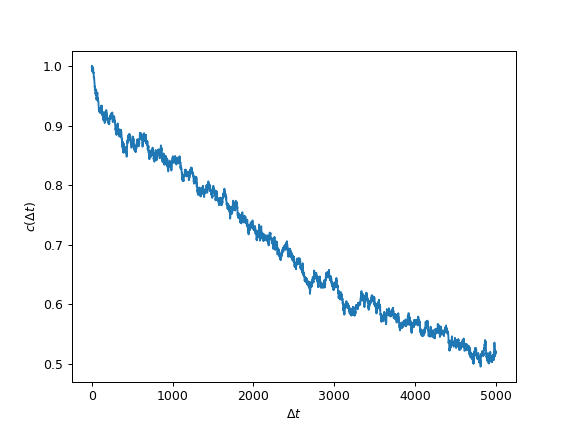

In [18]:
figure()
plot(np.linspace(0,s_time,s_time),meanReDt/meanReDt[0])
xlabel(r"$\Delta t$")
ylabel(r"$c(\Delta t)$")
show()

In [8]:
''' Aufgabe 2: Lineare Kette im Confinement (Spalt/Schlitz) '''

def setupLinChainInConfinement(N,box, periodicity):
    '''
    create single linear chain of length N in a cubic box of size box
    Input: linear chain lenght N ( int ), box size in one dimension ( int )
    Return: instance of BFMSimulator
    '''
    boxX, boxY, boxZ = box
    pX, pY, pZ = periodicity
    chainSim = BFMSimulator( [boxX, boxY, boxZ], [pX, pY, pZ] )
    
    if np.all(np.array([pX, pY, pZ])):
        steps = [(2,0,0),(0,2,0),(0,0,2)]
        start = [0,0,0]
    elif ( ( not pZ ) and ( not pY ) ):
        steps = [(2,0,0)]
        start = [0,int(boxY/2),int(boxZ/2)]
    elif ( (not pZ) and (pY) ):
        steps = [(2,0,0),(0,2,0)]
        start = [0,0,int(boxZ/2)]
    else:
        print("Warning: box periodicity {} not supported!".format(periodicity))
        
    attribute = {"fixed": False}

    for n in range(N):
        if (n > 0):
            step = steps[random.randint(len(steps))]
            coords = chainSim.molecules[-1].coords + step
            chainSim.addMonomer(coords,attribute)
            chainSim.connectMonomers(len(chainSim.molecules)-2,len(chainSim.molecules)-1)
        else:
            chainSim.addMonomer(np.array(start),attribute)
    
    # sanity check before return
    chainSim.checkConfig()
            
    return chainSim

applied moves / attempted moves:
43291 / 160000 = 0.27056875


<IPython.core.display.Javascript object>


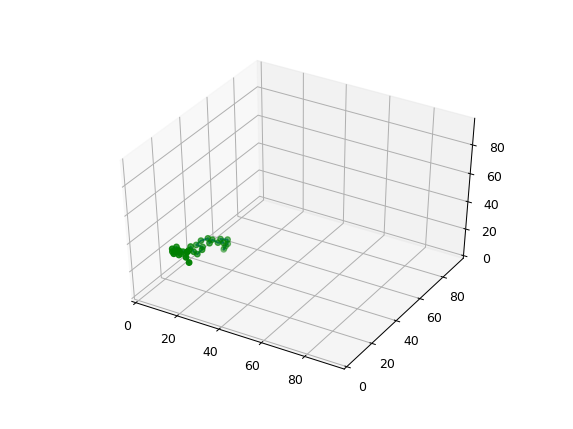

In [73]:
N = 32
box = [96, 96, 96]
period = [True, True, False]
confSim = setupLinChainInConfinement(N, box, period)
#confSim.plotConfig()
confSim.performMCS(5000)
confSim.plotConfig()

In [15]:
# Check Ree/ Rg for different slit sizes:
period = [True,True, False]
N = 32
boxXY = 64
boxZ = [64, 32, 16, 8, 4]

n_samples = 200
meanRee = []
meanRg2 = []

for z in boxZ:
    # setup config
    confChain = setupLinChainInConfinement(N,[boxXY, boxXY, z], period)
    # run equilibration ( 10k steps)
    confChain.performMCS(10000)
    # run long simulation to make measurements
    currentRee = np.zeros((3))
    currentRg2 = np.zeros((3))
    for n in range(n_samples):
        confChain.performMCS(2000)
        currentRee += np.array(calcRee(confChain)[0])
        currentRg2 += np.array(calcRg2(confChain)[0])
    print(z,": Ree = ", currentRee/n_samples,", Rg2 = ", currentRg2/n_samples)
    meanRee.append(currentRee/n_samples)
    meanRg2.append(currentRg2/n_samples)
    
print(boxZ, meanRee, meanRg2)
data = np.vstack((boxZ,np.array(meanRee)[:,0],np.array(meanRee)[:,1],np.array(meanRee)[:,2],np.array(meanRg2)[:,0],np.array(meanRg2)[:,2],np.array(meanRg2)[:,2]))
np.savetxt("slit_data_n32.dat",data)

64 : Ree =  [-1.755 -3.78   3.03 ] , Rg2 =  [21.7563916  26.82511719 21.92728516]
32 : Ree =  [1.22  1.905 1.45 ] , Rg2 =  [33.19556641 24.00839844 16.64910645]
16 : Ree =  [ 6.58   7.47  -0.085] , Rg2 =  [25.55944336 31.91616699  7.26960937]
8 : Ree =  [-10.205   2.83    0.07 ] , Rg2 =  [41.11428711 41.98869141  1.9667041 ]
4 : Ree =  [-2.885 -1.765  0.02 ] , Rg2 =  [62.00779297 68.20063477  0.23970703]
[64, 32, 16, 8, 4] [array([-1.755, -3.78 ,  3.03 ]), array([1.22 , 1.905, 1.45 ]), array([ 6.58 ,  7.47 , -0.085]), array([-10.205,   2.83 ,   0.07 ]), array([-2.885, -1.765,  0.02 ])] [array([21.7563916 , 26.82511719, 21.92728516]), array([33.19556641, 24.00839844, 16.64910645]), array([25.55944336, 31.91616699,  7.26960937]), array([41.11428711, 41.98869141,  1.9667041 ]), array([62.00779297, 68.20063477,  0.23970703])]


<IPython.core.display.Javascript object>


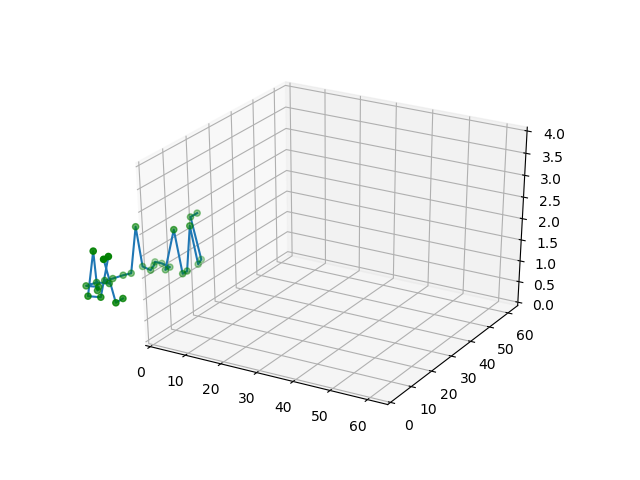

<IPython.core.display.Javascript object>


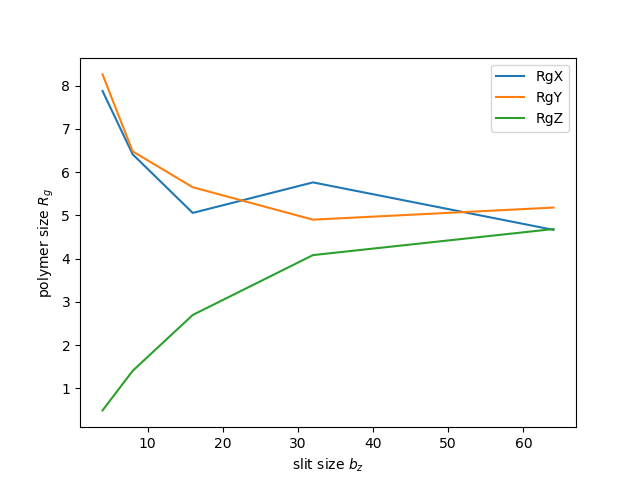

In [16]:
confChain.plotConfig()

figure()
plot(boxZ,np.sqrt(np.array(meanRg2)[:,0]), label = "RgX")
plot(boxZ,np.sqrt(np.array(meanRg2)[:,1]), label = "RgY")
plot(boxZ,np.sqrt(np.array(meanRg2)[:,2]), label = "RgZ")
legend(loc="best")
xlabel(r"slit size $b_{z}$")
ylabel(r"polymer size $R_{g}$")
show()

In [11]:
# Check Ree/ Rg for different pore sizes:
period = [True, False, False]
N = 32
boxX = 64
boxYZ = [64, 32, 16, 8, 4]

n_samples = 200
meanRee = []
meanRg2 = []

for yz in boxYZ:
    # setup config
    confChain = setupLinChainInConfinement(N,[boxX, yz, yz], period)
    # run equilibration ( 10k steps)
    confChain.performMCS(10000)
    # run long simulation to make measurements
    currentRee = np.zeros((3))
    currentRg2 = np.zeros((3))
    for n in range(n_samples):
        confChain.performMCS(1000)
        currentRee += np.array(calcRee(confChain)[0])
        currentRg2 += np.array(calcRg2(confChain)[0])
    print(yz,": Ree = ", currentRee/n_samples,", Rg2 = ", currentRg2/n_samples)
    meanRee.append(currentRee/n_samples)
    meanRg2.append(currentRg2/n_samples)
    
print(boxYZ, meanRee, meanRg2)
data = np.vstack((boxYZ,np.array(meanRee)[:,0],np.array(meanRee)[:,1],np.array(meanRee)[:,2],np.array(meanRg2)[:,0],np.array(meanRg2)[:,2],np.array(meanRg2)[:,2]))
np.savetxt("pore_data_n32.dat",data)

64 : Ree =  [8.04  2.    0.035] , Rg2 =  [30.87129883 16.43604004 22.42755859]
32 : Ree =  [-1.175 -1.05  -4.26 ] , Rg2 =  [33.17731934 15.7422168  17.51224609]
16 : Ree =  [ 8.215 -0.46   0.66 ] , Rg2 =  [49.88362305  7.51870605  8.33682617]
8 : Ree =  [34.235  0.09  -0.13 ] , Rg2 =  [128.13390137   2.08118164   2.12676758]
4 : Ree =  [ 6.2e+01 -5.0e-03 -7.0e-02] , Rg2 =  [3.41000000e+02 2.41542969e-01 2.42827148e-01]
[64, 32, 16, 8, 4] [array([8.04 , 2.   , 0.035]), array([-1.175, -1.05 , -4.26 ]), array([ 8.215, -0.46 ,  0.66 ]), array([34.235,  0.09 , -0.13 ]), array([ 6.2e+01, -5.0e-03, -7.0e-02])] [array([30.87129883, 16.43604004, 22.42755859]), array([33.17731934, 15.7422168 , 17.51224609]), array([49.88362305,  7.51870605,  8.33682617]), array([128.13390137,   2.08118164,   2.12676758]), array([3.41000000e+02, 2.41542969e-01, 2.42827148e-01])]


<IPython.core.display.Javascript object>


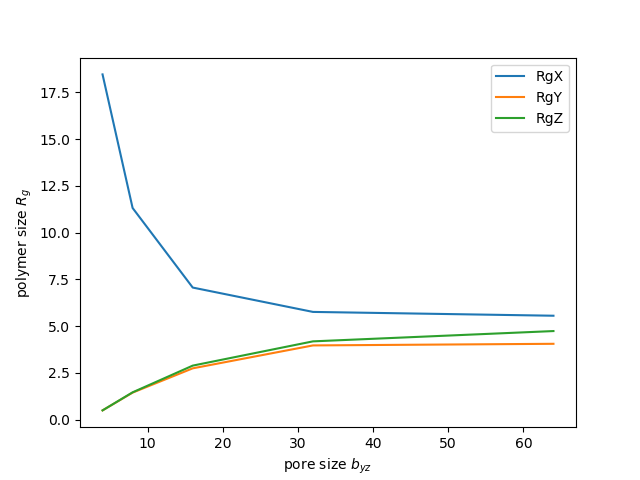

In [13]:
figure()
plot(boxYZ,np.sqrt(np.array(meanRg2)[:,0]), label = "RgX")
plot(boxYZ,np.sqrt(np.array(meanRg2)[:,1]), label = "RgY")
plot(boxYZ,np.sqrt(np.array(meanRg2)[:,2]), label = "RgZ")
legend(loc="best")
xlabel(r"pore size $b_{yz}$")
ylabel(r"polymer size $R_{g}$")
show()